# Make hexbin difference maps

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import scipy.stats
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator
import rioxarray as rxr
import pickle

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.facecolor']='w'
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'

plt.rcParams['font.size'] = '12'

In [4]:
pd.set_option('display.max_columns', None)

## Load in the Data:

In [18]:
atl06sr_gdf = pickle.load(open('../../../data/atl06/methow_all_sr-atl06-10172022_processed_bicubic_7912.pkl', 'rb'))

outline_gdf = pickle.load(open('../../../data/site_outlines/methow_outline_32610.pkl', 'rb'))

snwd = pickle.load(open('../../data/snotel/snotel_snwd_35.pkl', 'rb'))

cdec_geom = pickle.load(open('../../data/snotel/snotel_geometries.pkl', 'rb'))

streamlines_methow = pickle.load(open('../../../data/site_outlines/streamlines_methow.pkl', 'rb'))

methow_reverse = pickle.load(open('../../../data/site_outlines/methow_reverse.pkl', 'rb'))

streamlines_methow = pickle.load(open('../../../data/site_outlines/streamlines_methow.pkl', 'rb'))

In [19]:
hillshade = rxr.open_rasterio('../../../data/lidar/methow/dtm/methow_basin_2018_dtm_combined_32610_100m_hillshade.tif', masked=True).squeeze()

dtm = rxr.open_rasterio('../../../data/lidar/methow/dtm/methow_basin_2018_dtm_combined_32610_100m.tif', masked=True).squeeze()

In [20]:
# get the shapely object, not a GeoSeries
geom = cdec_geom[0:1].geometry.item()

# apply distance from a GeoSeries to the single shapely object
dist=outline_gdf.boundary.distance(geom)

In [21]:
atl06sr_gdf = atl06sr_gdf.rename(columns={'diff_plus_bicubic_update':'diff_plus_bicubic'})

In [22]:
atl06sr_gdf = atl06sr_gdf.to_crs('epsg:32610')

In [8]:
dist

3    4907.875423
dtype: float64

In [9]:
# get the shapely object, not a GeoSeries
geom = cdec_geom[1:2].geometry.item()

# apply distance from a GeoSeries to the single shapely object
outline_gdf.boundary.distance(geom)

3    5996.132033
dtype: float64

In [7]:
# Transform methow_reverse CRS. Only run once

# methow_reverse = gpd.read_file('../../../data/site_outlines/methow_reverse.geojson')
# methow_reverse = methow_reverse.to_crs('epsg:32610')
# methow_reverse = gpd.overlay(methow_reverse, outline_gdf, how='difference')

# # Save the reverse geodataframe
# out_fn = '../../../data/site_outlines/methow_reverse.pkl'

# with open(out_fn, 'wb') as f:
#     pickle.dump(methow_reverse, f)

## Remove Outliers  

In [27]:
atl06sr_gdf['zscore'] = (atl06sr_gdf['diff_plus_bicubic'] - atl06sr_gdf['diff_plus_bicubic'].mean()) / atl06sr_gdf['diff_plus_bicubic'].std()

zscore_thresh = 3
absdiff_thresh = 5.0

In [28]:
# trying to get different zscore values for snow on versus snow off values

atl06_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh)

inner_snowoff_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus_bicubic'].abs() <=absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 0)

inner_snowon_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus_bicubic'].abs() <=absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 1)

In [29]:
atl06sr_gdf_inner = atl06sr_gdf[atl06_idx]

### Create the hex map:

Text(0.5, 1.0, 'ATL06SR Snow On - DEM')

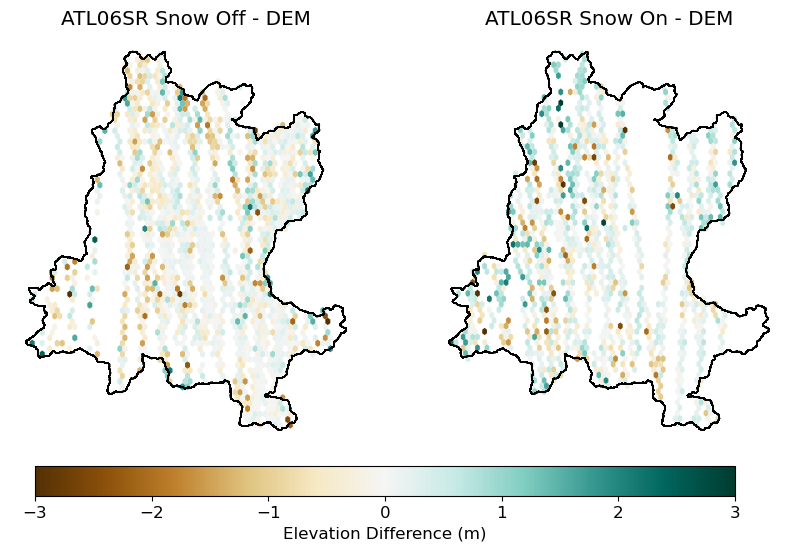

In [39]:
fig, ax = plt.subplots(1,2, figsize=(10,10))

hb_off = ax[0].hexbin(atl06sr_gdf[inner_snowoff_idx].geometry.x, 
               atl06sr_gdf[inner_snowoff_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowoff_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, vmin=-3, vmax=3, edgecolors='none')

hb_on = ax[1].hexbin(atl06sr_gdf[inner_snowon_idx].geometry.x, 
               atl06sr_gdf[inner_snowon_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowon_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, vmin=-3, vmax=3, edgecolors='none')

outline_gdf.plot(ax=ax[0], facecolor='none', edgecolor='k')
outline_gdf.plot(ax=ax[1], facecolor='none', edgecolor='k')

for axis in ax:
    axis.set_axis_off()

# https://stackoverflow.com/questions/13784201/how-to-have-one-colorbar-for-all-subplots
fig.subplots_adjust(top=0.8)
cbar_ax = fig.add_axes([0.15, 0.2, 0.7, 0.03])
plt.colorbar(hb_on, cax=cbar_ax, label='Elevation Difference (m)', orientation='horizontal')

#plt.tight_layout()
ax[0].set_title('ATL06SR Snow Off - DEM')
ax[1].set_title('ATL06SR Snow On - DEM')

Text(0.5, 1.0, 'ATL06SR Snow On - DEM')

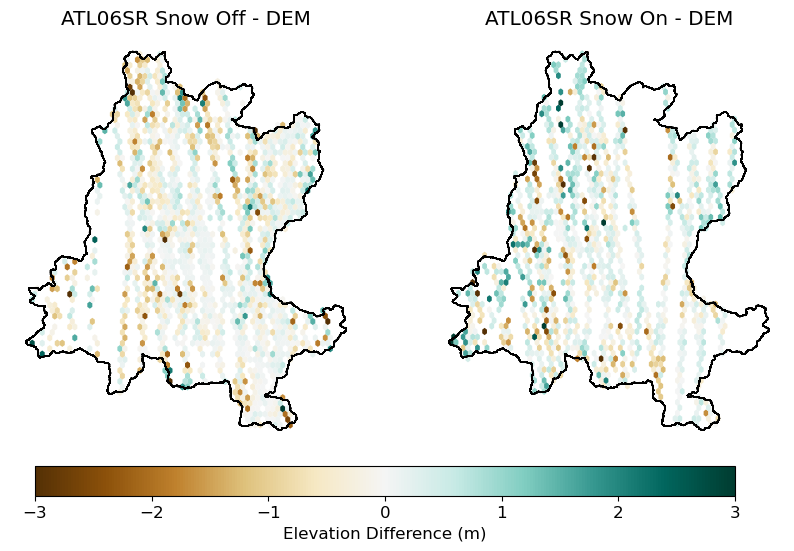

In [38]:
fig, ax = plt.subplots(1,2, figsize=(10,10))

hb_off = ax[0].hexbin(atl06sr_gdf[atl06sr_gdf['snow_presence']==0].geometry.x, 
               atl06sr_gdf[atl06sr_gdf['snow_presence']==0].geometry.y, 
               C=atl06sr_gdf[atl06sr_gdf['snow_presence']==0]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, vmin=-3, vmax=3, edgecolors='none')

hb_on = ax[1].hexbin(atl06sr_gdf[atl06sr_gdf['snow_presence']==1].geometry.x, 
               atl06sr_gdf[atl06sr_gdf['snow_presence']==1].geometry.y, 
               C=atl06sr_gdf[atl06sr_gdf['snow_presence']==1]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, vmin=-3, vmax=3, edgecolors='none')

outline_gdf.plot(ax=ax[0], facecolor='none', edgecolor='k')
outline_gdf.plot(ax=ax[1], facecolor='none', edgecolor='k')

for axis in ax:
    axis.set_axis_off()

# https://stackoverflow.com/questions/13784201/how-to-have-one-colorbar-for-all-subplots
fig.subplots_adjust(top=0.8)
cbar_ax = fig.add_axes([0.15, 0.2, 0.7, 0.03])
plt.colorbar(hb_on, cax=cbar_ax, label='Elevation Difference (m)', orientation='horizontal')

#plt.tight_layout()
ax[0].set_title('ATL06SR Snow Off - DEM')
ax[1].set_title('ATL06SR Snow On - DEM')

## Add another Row with Hillshade and other characteristics

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_69471/3070634029.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


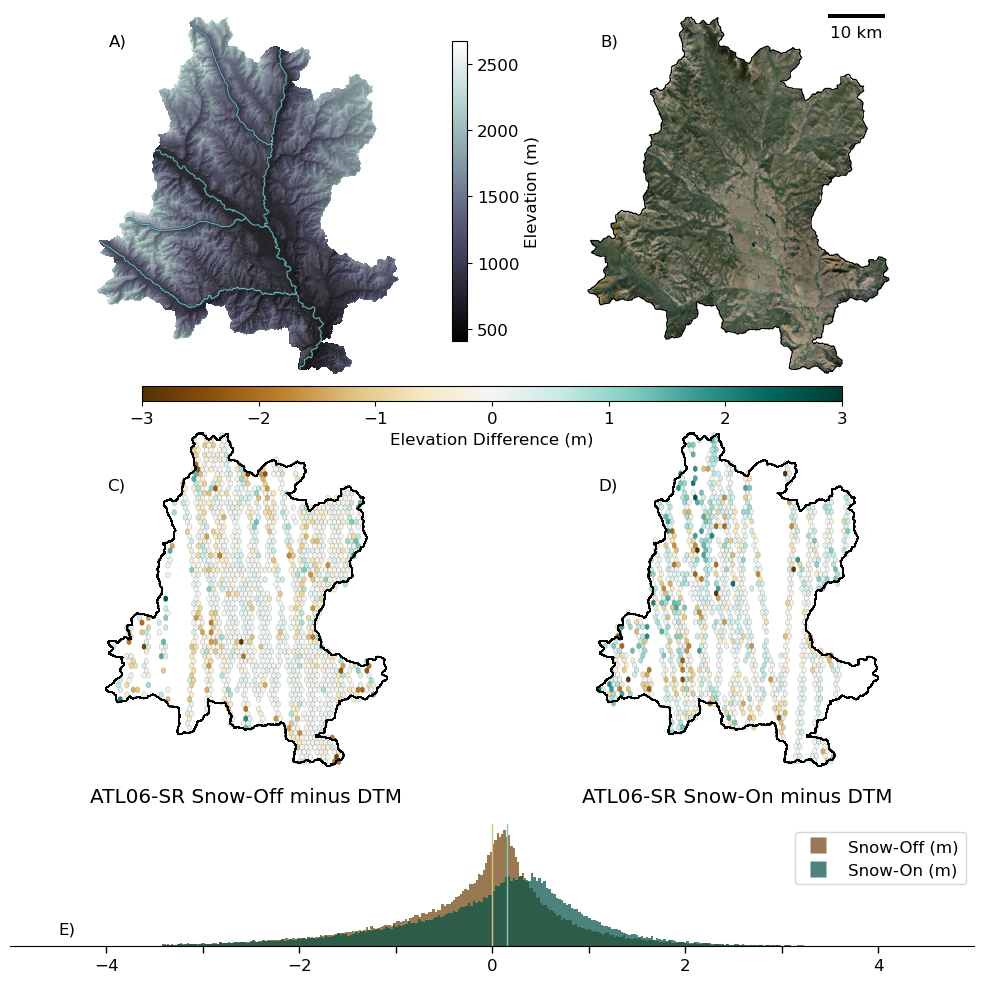

In [30]:
# add histograms to difference plots as a single plot
basemap = cx.providers.Esri.WorldImagery
norm = matplotlib.colors.Normalize(vmin=-5, vmax=5)
cmap = matplotlib.cm.get_cmap('BrBG')

fig, ax = plt.subplot_mosaic([['a', 'b'],
                             ['c', 'd'],
                             ['e', 'e']], figsize=(10,10), gridspec_kw={'height_ratios': [3, 3, 1], 'width_ratios': [1,1]})

c = dtm.plot(cmap='bone', ax=ax['a'], add_colorbar=False) #, cbar_kwargs={'label':'Elevation (m)'}
#chm.plot(cmap='Greens', ax=ax[0,0], add_colorbar=True, vmin=0, vmax=20, cbar_kwargs={'label':'Canopy Height (m)','shrink':0.9}, alpha=0.8)
hillshade.plot(cmap='Greys', ax=ax['a'], add_colorbar=False, alpha=0.3)
streamlines_methow.plot(ax=ax['a'], color='darkslategrey', linewidth=1.5, alpha=0.8)
streamlines_methow.plot(ax=ax['a'], color='skyblue', linewidth=0.5, alpha=1)
ax['a'].set_xlim(678000, 731300)
ax['a'].set_ylim(5347000, 5411000)
ax['a'].set_title('')
ax['a'].annotate(text='A)', xy=(0.05,0.9), xycoords='axes fraction')
ax['a'].set_xlabel('')
ax['a'].set_ylabel('')

ax['b'].add_artist(ScaleBar(1))
outline_gdf.plot(ax=ax['b'], facecolor='none', edgecolor='k')
cx.add_basemap(ax['b'], attribution=False, crs=atl06sr_gdf.crs.to_string(), source=basemap, zoom=12)
methow_reverse.plot(ax=ax['b'], facecolor='white')
ax['b'].set_xlim(678000, 731300)
ax['b'].set_ylim(5347000, 5411000)
# ax[0,1].axes.xaxis.set_ticks([])
# ax[0,1].axes.yaxis.set_ticks([])
ax['b'].annotate(text='B)', xy=(0.05,0.9), xycoords='axes fraction')
ax['b'].set_title('')



hb_off = ax['c'].hexbin(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0].geometry.x, 
               atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0].geometry.y, 
               C=atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0]['diff_plus_bicubic'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, vmin=-3, vmax=3, edgecolors='k', linewidth=.075)
ax['c'].set_axis_off()
ax['c'].annotate(text='C)', xy=(0.05,0.8), xycoords='axes fraction')
ax['c'].set_title('ATL06-SR Snow-Off minus DTM', y=0, pad=-14)


hb_on = ax['d'].hexbin(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1].geometry.x, 
               atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1].geometry.y, 
               C=atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1]['diff_plus_bicubic'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, edgecolors='k', linewidth=.075, vmin=-3, vmax=3)
ax['d'].set_axis_off()
ax['d'].annotate(text='D)', xy=(0.05,0.8), xycoords='axes fraction')

outline_gdf.plot(ax=ax['c'], facecolor='none', edgecolor='k')
outline_gdf.plot(ax=ax['d'], facecolor='none', edgecolor='k')
ax['d'].set_title('ATL06-SR Snow-On minus DTM', y=0, pad=-14)


ax['e'].hist(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0]['diff_plus_bicubic'], color=cmap(norm(-4.5)),\
            bins=int(np.sqrt(len(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0]))), alpha=0.7)
ax['e'].axvline(x = np.nanmedian(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0]['diff_plus_bicubic']), c=cmap(norm(-2)), linewidth=1)
ax['e'].tick_params('both', length=5, width=1, which='major')
ax['e'].tick_params('both', length=5, width=1, which='minor')
#add lines for the standard deviation
# ax['e'].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']) + 
#                 np.nanstd(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), c=cmap(norm(-1)), linewidth=0.5)
# ax['e'].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']) - 
#                 np.nanstd(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), c=cmap(norm(-1)), linewidth=0.5)

# Hide the right and top spines
ax['e'].spines.right.set_visible(False)
ax['e'].spines.top.set_visible(False)
ax['e'].spines.left.set_visible(False)
ax['e'].axes.yaxis.set_visible(False)
ax['e'].set_xlim(-5,4.99)
ax['e'].annotate(text='E)', xy=(0.05,0.1), xycoords='axes fraction')
ax['e'].set

ax['e'].hist(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1]['diff_plus_bicubic'], color=cmap(norm(4.5)),\
            bins=int(np.sqrt(len(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1]))), alpha=0.7)
ax['e'].axvline(x = np.nanmedian(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1]['diff_plus_bicubic']), c=cmap(norm(2)), linewidth=1)

#Add minor ticks between the labels
minor_locator = AutoMinorLocator(2)
ax['e'].xaxis.set_minor_locator(minor_locator)
# ax['e'].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowon_idx]['diff_plus']) + 
#                 np.nanstd(atl06sr_gdf[inner_snowon_idx]['diff_plus']), c=cmap(norm(1)), linewidth=0.5)
# ax['e'].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowon_idx]['diff_plus']) -
#                 np.nanstd(atl06sr_gdf[inner_snowon_idx]['diff_plus']), c=cmap(norm(1)), linewidth=0.5)

ax['e'].spines.right.set_visible(False)
ax['e'].spines.top.set_visible(False)
ax['e'].spines.left.set_visible(False)
ax['e'].axes.yaxis.set_visible(False)

ax['a'].spines['bottom'].set_color('white')
ax['a'].spines['top'].set_color('white')
ax['a'].spines['left'].set_color('white')
ax['a'].spines['right'].set_color('white')
ax['a'].axes.get_xaxis().set_ticks([])
ax['a'].axes.get_yaxis().set_ticks([])

ax['b'].spines['bottom'].set_color('white')
ax['b'].spines['top'].set_color('white')
ax['b'].spines['left'].set_color('white')
ax['b'].spines['right'].set_color('white')
ax['b'].axes.get_xaxis().set_ticks([])
ax['b'].axes.get_yaxis().set_ticks([])
        
# https://stackoverflow.com/questions/13784201/how-to-have-one-colorbar-for-all-subplots
fig.subplots_adjust(top=0.8)
cbar_ax = fig.add_axes([.15, 0.59, 0.7, 0.015])
plt.colorbar(hb_on, cax=cbar_ax, label='Elevation Difference (m)', orientation='horizontal')
cbar_ax2 = fig.add_axes([0.46, 0.65, 0.015, 0.3])
plt.colorbar(c, cax=cbar_ax2, label='Elevation (m)', orientation='vertical')


# MAKE A LEGEND
custom = [Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=cmap(norm(-4.5), alpha=0.7), linestyle='None'),
        Line2D([], [], marker='s', markersize=12, markeredgecolor='none', color=cmap(norm(4.5), alpha=0.7), linestyle='None')
          ]
custom_labels = ['Snow-Off (m)', 'Snow-On (m)']

ax['e'].legend(custom, custom_labels, loc='upper right')

plt.tight_layout()

plt.savefig('../../figures/polished/difference_map_hist_w-hillshade.jpeg', dpi=500)

In [21]:
(np.max(atl06sr_gdf.geometry.x) - np.min(atl06sr_gdf.geometry.x)) / 60

836.4615249113762

### Determine the skew of the snow on and snow off data:

In [32]:
scipy.stats.skew(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1]['diff_plus_bicubic'], nan_policy='omit')

-0.5533393552374858

In [33]:
scipy.stats.skewtest(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==1]['diff_plus_bicubic'], nan_policy='omit')

SkewtestResult(statistic=-54.160345889664114, pvalue=0.0)

In [34]:
scipy.stats.skew(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0]['diff_plus_bicubic'], nan_policy='omit')

-0.4676902517342178

In [35]:
scipy.stats.skewtest(atl06sr_gdf_inner[atl06sr_gdf_inner['snow_presence']==0]['diff_plus_bicubic'], nan_policy='omit')

SkewtestResult(statistic=-50.99424385795788, pvalue=0.0)

In [221]:
from scipy import stats

def iqr2(x):
    IQR = stats.iqr(x, interpolation = 'midpoint')
    return IQR

In [222]:
iqr2(atl06sr_gdf[inner_snowon_idx]['diff_plus'])

1.5704840071178978

In [223]:
iqr2(atl06sr_gdf[inner_snowoff_idx]['diff_plus'])

1.2430893767943871